# Preamble

In [19]:
%load_ext autoreload
%autoreload 2

# disable parallelization for BLAS and co.
from nalabtools.utils.parallelization import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)

# general
import re
import collections
import pickle

# data
import numpy as np
import pandas as pd

# ml / stats
import scipy
import sklearn

# plotting
import matplotlib.pyplot as plt

# nalab
import nalabtools

# init notebook files
import nalabtools.utils.misc
nb = nalabtools.utils.misc.NotebookContext("butterfly___martin_007_deepinsight_embeddings")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/mgbckr/mnt/nalab/workspaces/nalab-tools/src/nalabtools/utils/parallelization.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


In [20]:
import time

In [21]:
def format_duration(totsec):
    h = totsec//3600
    m = (totsec%3600) // 60
    sec =(totsec%3600)%60 #just for reference
    print("%dh %dm %ds" %(h,m,sec))

In [22]:
import rpy2
rpy2.__version__

'3.3.2'

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
R.home()

[1] "/home/mgbckr/miniconda3/envs/butterfly/lib/R"


# Load data

In [10]:
import pathlib
import nalabdata.fcs.load
import nalabdata.fcs.meta

In [11]:
# immune clock
tmp_fcs_path = pathlib.Path(nb.file("tmp_fcs_immuneclock.pickle"))
if tmp_fcs_path.exists():

    print("Loading from temp file")
    data_immuneclock_meta, data_immuneclock_fcs = pickle.load(open(tmp_fcs_path, "rb"))
    
else:
    
    print("Loading from FCS files; this may take a while ...")
    
    path = pathlib.Path("../../nalab-data/data/large/fcs/immune_clock/AllImmuneClock")
    files = list((path / "Training").glob("*")) + list((path / "Validation").glob("*"))

    selected_files = files
    data_immuneclock_meta = nalabdata.fcs.meta.meta_from_filenames(selected_files, context="immune_clock", ga_sources_path="../../nalab-data/data/default/multiomics")
    data_immuneclock_fcs = nalabdata.fcs.load.load_fcs(
        selected_files,  
        cell_filter="granulocytes", 
        n_cells_sample=10000,
        n_jobs=64)
    
    pickle.dump((data_immuneclock_meta, data_immuneclock_fcs), open(tmp_fcs_path, "wb"))

Loading from temp file


In [12]:
import nalabdata.fcs
data_fcs = data_immuneclock_fcs[nalabdata.fcs.load.filter_columns(data_immuneclock_fcs.columns)]

In [13]:
data_fcs

,CD235ab_CD61,CD45,CD66,CD7,CD19,CD45RA,CD11b,CD4,CD8a,CD11c,...,ERK,CCR9,CD25,CD3,CCR7,CD15,CCR2,HLADR,CD14,CD56
file_index,,,,,,,,,,,,,,,,,,,,,
0,0.109946,2.496170,4.209940,0.254132,0.000000,1.270893,3.813384,0.832684,0.177333,0.568260,...,0.114735,0.302329,0.048255,0.000000,1.402996,4.320698,0.830888,0.539162,0.698561,1.002160
0,0.000000,2.448505,3.226358,0.348798,0.461272,0.465805,4.372060,0.101652,0.000902,1.899516,...,0.941218,0.646752,0.000000,0.000000,1.543148,4.307781,1.069659,0.774400,0.336641,0.540931
0,0.000000,3.705167,5.674930,0.377351,0.169603,1.042656,4.358280,0.039475,0.100833,0.917864,...,0.078937,0.295043,0.000000,0.471177,4.454113,6.142947,2.839626,0.966267,0.173192,0.728520
0,0.144858,4.266652,1.399618,2.686234,0.191140,3.354222,0.705526,3.300746,0.575721,0.000000,...,1.014223,0.300559,0.000000,5.107750,0.724747,0.000000,0.000000,0.000000,0.000000,1.254241
0,0.236731,4.439890,1.236828,2.915460,0.200004,2.749881,0.944271,3.433861,0.238781,0.000000,...,0.448964,0.893632,0.049316,4.975746,0.923344,0.808175,0.000000,0.329970,0.112082,1.136044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.134958,2.457091,2.995368,0.458581,4.632334,1.445672,3.790353,0.518855,0.423147,1.345447,...,0.263239,0.075312,2.854015,0.065787,2.669849,3.966354,0.593001,0.000000,0.005160,0.732052
123,0.000000,1.826526,3.255615,0.055278,4.215872,0.868226,3.972158,0.612692,0.000000,0.965600,...,0.677912,0.588470,2.450716,0.000000,1.627452,2.803457,0.768832,0.000000,0.106218,0.043010
123,0.542979,1.027731,2.657280,0.108171,4.104208,1.906557,3.977347,0.000000,0.480218,1.035703,...,0.665782,0.513563,2.159219,0.274441,2.147174,3.672987,0.000000,0.937510,0.000000,0.745350


## AFCS

In [14]:
# import nalabafcs.automate.run.steps
# import pathlib
# path = pathlib.Path(nb.file("fcs_temp.pickle"))
# if path.exists():
#     print("Loading from temp file")
#     data_fcs = pickle.load(open(path, "rb"))
# else:
#     print("Loading from FCS files")
#     data_fcs = nalabafcs.automate.run.steps.load_fcs(n_jobs=100)
# pickle.dump(data_fcs, open(path, "wb"))

In [15]:
# data_fcs.shape

In [16]:
# data_fcs.index.unique().shape[0] / 4

## Normalization

In [17]:
preprocessing = sklearn.preprocessing.MinMaxScaler().fit(data_fcs.values)
data_features = preprocessing.transform(data_fcs.values.copy(order="C"))

# Test embeddings

Embedding packages:
* https://github.com/DmitryUlyanov/Multicore-TSNE
* https://github.com/pavlin-policar/openTSNE
* https://github.com/CannyLab/tsne-cuda
* https://github.com/lmcinnes/umap
* https://github.com/eamid/trimap
* https://github.com/rapidsai/cuml (GPU powered)

In [18]:
test_data = data_features

## TSNE

In [40]:
import sklearn.manifold

In [ ]:
start = time.time()
embedding_sk = sklearn.manifold.TSNE(n_components=2).fit_transform(test_data)
duration_sk = time.time() - start

In [ ]:
format_duration(duration_sk)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].scatter(embedding_sk[:,0], embedding_sk[:,1])
axes[1].hist2d(embedding_sk[:,0], embedding_sk[:,1], bins=50);

## Rapids TSNE

In [24]:
from cuml.manifold import TSNE as TSNE_rapids

In [25]:
start = time.time()
embedding_rp = TSNE_rapids(n_components = 2).fit_transform(test_data)
duration_kp = time.time() - start

In [26]:
format_duration(duration_kp)

0h 1m 59s


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].scatter(embedding_rp[:,0], embedding_rp[:,1])
axes[1].hist2d(embedding_rp[:,0], embedding_rp[:,1], bins=50);

## Multicore TSNE

In [54]:
import MulticoreTSNE
# MulticoreTSNE.__version__

In [55]:
# %%time
# tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=1)
# embedding = tsne.fit_transform(test_data)

In [ ]:
start = time.time()
embedding_mt = MulticoreTSNE.MulticoreTSNE(n_jobs=100).fit_transform(test_data)
duration_mt = time.time() - start

In [85]:
format_duration(duration_mt)

1h 34m 24s


In [ ]:
plt.hist2d(embedding_mt[:,0], embedding_mt[:,1], bins=50, );

## openTSNE

**WARNING**: seems to hang the kernel at least with pynndescent-0.3.3 ... let's try 0.4.6 which worked on my laptop ... nope, also hangs the kernel ... wtf???

In [50]:
import openTSNE
openTSNE.__version__

'0.3.12'

In [51]:
start = time.time()
embedding_ot = openTSNE.TSNE(n_jobs=100).fit(test_data)
duration_ot = time.time() - start

In [86]:
format_duration(duration_ot)

0h 21m 18s


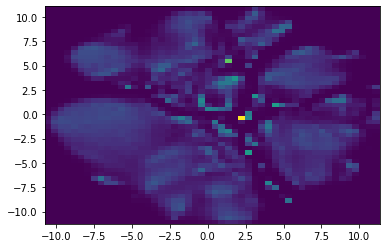

In [53]:
plt.hist2d(embedding_ot[:,0], embedding_ot[:,1], bins=50, );

## FitSNE

**WARNING**: kills the kernel if `n < m`


In [34]:
import fitsne

In [35]:
start = time.time()
embedding_ft = fitsne.FItSNE(np.ascontiguousarray(test_data), nthreads=100)
duration_ft = time.time() - start

In [87]:
format_duration(duration_ft)

0h 17m 15s


In [ ]:
plt.hist2d(embedding_ft[:,0], embedding_ft[:,1], bins=40, );

## Trimap

In [38]:
import trimap
trimap.__version__

'1.0.13'

In [39]:
start = time.time()
embedding_tm = trimap.TRIMAP().fit_transform(test_data)
duration_tm = time.time() - start

TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean,lr=1000.0, n_iters=400, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 840000 points with dimension 37
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 18862.326, Violated triplets: 0.0408
Iteration:  200, Loss: 16833.502, Violated triplets: 0.0364
Iteration:  300, Loss: 15701.461, Violated triplets: 0.0340
Iteration:  400, Loss: 14985.802, Violated triplets: 0.0324
Elapsed time: 0:41:27.672711


In [88]:
format_duration(duration_tm)

0h 41m 27s


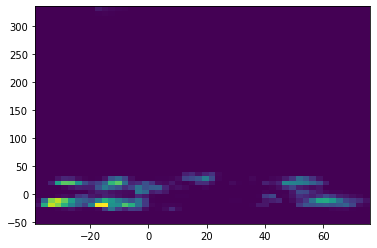

In [41]:
plt.hist2d(embedding_tm[:,0], embedding_tm[:,1], bins=50, );

## UMAP

In [61]:
import umap
umap.__version__

'0.3.10'

In [47]:
start = time.time()
embedding_umap = umap.UMAP().fit_transform(test_data)
duration_um = time.time() - start

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../miniconda3/envs/analysis3.7/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..

In [84]:
format_duration(duration_um)

0h 49m 48s


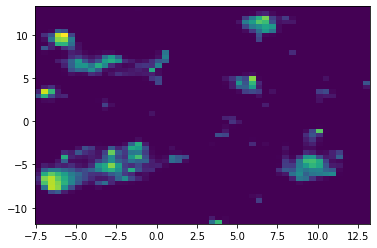

In [49]:
plt.hist2d(embedding_umap[:,0], embedding_umap[:,1], bins=50, );

## PCA

In [35]:
import sklearn.decomposition
sklearn.__version__

'0.23.1'

In [36]:
start = time.time()
embedding_pca = sklearn.decomposition.PCA(n_components=2).fit_transform(test_data)
duration_pca = time.time() - start

In [37]:
format_duration(duration_pca)

0h 0m 19s


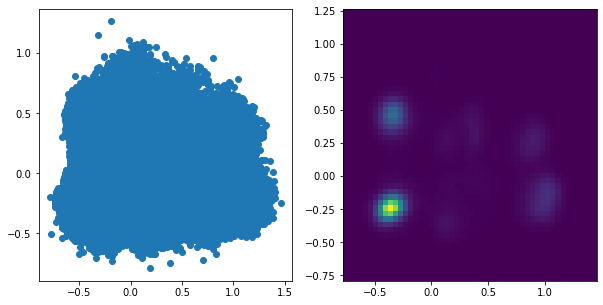

In [38]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].scatter(embedding_pca[:,0], embedding_pca[:,1])
axes[1].hist2d(embedding_pca[:,0], embedding_pca[:,1], bins=50);

## Kernel PCA

**WARNING**: Memory error for > 100000 samples

In [29]:
import sklearn.decomposition
sklearn.__version__

'0.23.1'

In [30]:
start = time.time()
embedding_kp = sklearn.decomposition.KernelPCA(n_components=2, kernel="rbf").fit_transform(test_data[:1000,:])
duration_kp = time.time() - start

In [31]:
format_duration(duration_kp)

0h 0m 0s


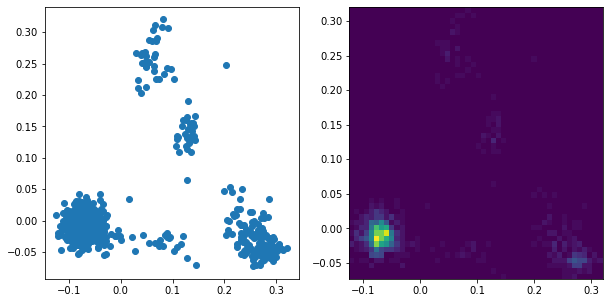

In [34]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].scatter(embedding_kp[:,0], embedding_kp[:,1])
axes[1].hist2d(embedding_kp[:,0], embedding_kp[:,1], bins=50);